In [1]:
%%capture --no-stderr

# 패키지 설치

# %pip install -U langgraph langsmith

# 클로드 API를 사용하기 위해서 설치해야 됨
# 랭그래프와는 상관이 없고, 예시를 위해서 사용
#%pip install -U langchain_anthropic

In [2]:
from dotenv import load_dotenv
load_dotenv('../envls')

import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [3]:
# 랭스미스 설정
#print(os.getenv("LANGSMITH_API_KEY"))

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [4]:
# 1부 기본 챗봇 구축
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

"""
State() 함수는 Dict 타입이며, 'messages' 단일키이다.
"""
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 그래프 빌더 정의
graph_builder = StateGraph(State)

In [5]:

from langchain_anthropic import ChatAnthropic
from langserve import RemoteRunnable

# llm = ChatAnthropic(model="claude-3-haiku-20240307")

# 예제의 클로드대신 로컬 gemma2를 사용
llm = RemoteRunnable("http://sllm.repia.com:28000/llm/") # gemma2


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# 첫 번째 인수는 노드 이름이다.
# 두 번째 인수는 노드가 사용될때마다 사용되는 함수나 객체이다.
graph_builder.add_node("chatbot", chatbot)

In [6]:
# 시작 지점 정의
graph_builder.add_edge(START, 'chatbot')

# 종료 지점 정의
graph_builder.add_edge('chatbot', END)

In [7]:
# CompileGraph 그래프 생성, invoke()할 수 있는 상태이다.
graph = graph_builder.compile()

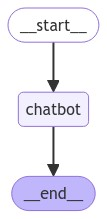

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! 👋  How can I help you today? 😊
Assistant: 저는 Gemma입니다. Google DeepMind에서 훈련된 오픈 소스 챗봇입니다.
Assistant: 감사합니다! 😊 무엇이 훌륭하다고 생각하시나요?  더 자세히 말씀해주시면 기쁘겠습니다! 😄
Assistant: 알겠습니다. 앞으로는 스마트 AI라고 부르세요. 어떤 도움을 드릴까요? 😊  

Assistant: 저는 Gemma입니다. Google DeepMind에서 훈련된 오픈 소스 대형 언어 모델입니다.
Assistant: 네, 앞으로 저의 이름은 스마트AI입니다. 

어떤 도움을 드릴까요? 😊  



Assistant: 저는 Gemma입니다. 구글에서 훈련된 오픈 소스 AI 어시스턴트입니다.
Assistant: 좋아요! 어떻게 도와드릴까요? 😄  궁금한 점이 있으시면 언제든지 물어보세요. 😊
Assistant: 한국의 수도는 **서울**입니다. 😊  


Let me know if you have any other questions about Korea! 🇰🇷 

Assistant: ## LangGraph: 언어 모델 이해를 위한 새로운 도구

LangGraph는 **언어 모델의 내부 구조와 동작을 시각화하고 분석하는 데 사용되는 도구**입니다. 핵심은 **"변수 그래프"**라는 개념으로, 언어 모델이 학습 과정에서 다루는 모든 변수(매개변수, 토큰 등)와 이들이 어떻게 연결되어 있는지를 나타냅니다.

**LangGraph를 사용하면 다음과 같은 분석이 가능합니다:**

* **언어 모델의 복잡성 파악**: 
모델 내부에 존재하는 노드와 에지의 수, 그래프 구조 등을 통해 모델의 크기와 복잡도를 시각적으로 이해할 수 있습니다.
* **변수 간 상호 작용 분석**: 두 변수 사이의 연결 강도를 파악하여 어떤 변수들이 다른 변수에 영향을 주는지, 또는 특정 작업에 중요한 변수 집합이 무엇인지를 찾아낼 수 있습니다.
* **모델 학습 과정 시각화**:

In [3]:
%%capture --no-stderr
# 2부: 외부 검색 도구를 사용하여 더 나은 답변을 할 수 있도록 챗봇을 강화


# %pip install -U tavily-python # 검색API
# %pip install -U langchain_community

In [4]:
# 타빌리 서치 API KEY 확인
_set_env("TAVILY_API_KEY")

In [5]:
# 타빌리 서치 API를 도구로 등록 및 단위 테스트
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

# 타빌리 서치 API 단위 테스트
# tool.invoke("What's a 'node' in LangGraph?")

# 타빌리 서치에서 URL과 페이지 요약을 리턴해 줌
# 채팅봇을 이 요약을 활용하여 답변을 구성할 예정

In [6]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from sqlalchemy import TypeDecorator
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

from langserve import RemoteRunnable

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# llm = RemoteRunnable("http://sllm.repia.com:28000/llm/") # gemma2
# tool_calling를 지원하는 것은 Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.
# 앞으로 RemoteRunnable가 가능해야한다. 아니면 가능한 llm을 찾아야 한다.
llm = ChatAnthropic(model="claude-3-haiku-20240307")

# LLM이 호출할 수 있는 툴을 알려줌
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 챗봇 노드 생성
graph_builder.add_node('chatbot', chatbot)

In [7]:
import json
from langchain_core.messages import ToolMessage

"""
    가장 최근의 AI메시지를 바탕으로 도구를 실행하는 노드
    
"""

class BasicToolNode:
    """ A node that runs the tools requested in the last AIMessage. """

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
            print(3, message)
        else:
            raise ValueError("No message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"],
                )
            )
        return  {"messages": outputs}

# tool_node = BasicToolNode(tools = tools)
tool_node = BasicToolNode(tools = [tool])
graph_builder.add_node("tools", tool_node)

In [8]:
from typing import Literal

"""

"""
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    마지막 메시지에 도구 호출이 있는 경우 ToolNode로 라우팅하기 위한 함수
    conditional_edge에서 사용하며, 해당 사항이 없으면 종료 호출
    """

    if isinstance(state, list):
        ai_message = state[-1]
        print(1, ai_message)
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
        print(2, ai_message)
    else:
        raise ValueError(f"No messasges found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", "__end__": "__end__"},
)

graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START, 'chatbot')

graph = graph_builder.compile()

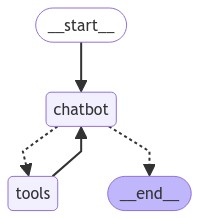

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}, debug=True):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)


[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [('user', '트럼프의 나이는?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', '트럼프의 나이는?')]
[1:tasks] Starting step 1 with 1 task:
- chatbot -> {'messages': [HumanMessage(content='트럼프의 나이는?', id='5086dcc1-21a6-4f4c-b95e-29834711a59e')]}
2 content=[{'id': 'toolu_015biiWmgRV32s653bVsHXe2', 'input': {'query': '트럼프 나이'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}] response_metadata={'id': 'msg_01WYv7qJ4gmxwxB367KZPVqM', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 378, 'output_tokens': 64}} id='run-a8110b14-747d-4bdf-b335-e8ed1ec20002-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '트럼프 나이'}, 'id': 'toolu_015biiWmgRV32s653bVsHXe2'}] usage_metadata={'input_tokens': 378, 'output_tokens': 64, 'total_tokens': 442}
Assistant: [{'id': 'toolu_015biiWmgRV32s653bVsHXe2', 'input': {'query': '트럼프 나이'}, 'nam